In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
train=pd.read_csv('/Users/abhisheksingh/Downloads/store price/train 2.csv',parse_dates=True)
test=pd.read_csv('/Users/abhisheksingh/Downloads/store price/test (1).csv',parse_dates=True)
store=pd.read_csv('/Users/abhisheksingh/Downloads/store price/stores.csv')
oil=pd.read_csv('/Users/abhisheksingh/Downloads/store price/oil.csv',parse_dates=True)
holidays_events=pd.read_csv('/Users/abhisheksingh/Downloads/store price/holidays_events.csv',parse_dates=True)
sample_submission=pd.read_csv('/Users/abhisheksingh/Downloads/store price/sample_submission.csv')

train


In [2]:
holidays_events=holidays_events[holidays_events['date']>='2013-01-01']
holidays_events=holidays_events.drop(['description'],axis=1)

filter1=(holidays_events['type'].isin(['Holiday','Additional','Transfer','Bridge','Event'])) & (holidays_events['transferred']==False)
filter2=holidays_events['type']=='Work Day'
holidays_events['is_holiday']=np.where(filter2,0,np.where(filter1,1,0))

holidays_events=holidays_events.drop(['transferred'],axis=1)
holidays_events.rename(columns={'type':'holiday_type'},inplace=True)

f=holidays_events['locale']=='Local'
holidays_events.loc[f,'locale']='city'
f=holidays_events['locale']=='Regional'
holidays_events.loc[f,'locale']='state'

store=store.drop(['cluster','type'],axis=1)

def data(t):
    t= t.merge(oil,'left','date')
    t['dcoilwtico']=t['dcoilwtico'].fillna(method='ffill')
    t['dcoilwtico']=t['dcoilwtico'].fillna(method='bfill')

    t=t.merge(store,'left','store_nbr')
    
    t.rename(columns={'city':'locale_name'},inplace=True)

    filter=holidays_events['locale']=="National"
    national_holidays=holidays_events[filter]

    t1=t.merge(national_holidays,'left','date')

    t1=t1.drop(['holiday_type','locale','locale_name_y'],axis=1)

    t1.rename(columns={'locale_name_x':'locale_name'},inplace=True)

    filter=holidays_events['locale']=="city"
    city_holidays=holidays_events[filter]

    t2=t1.merge(city_holidays,'left',on=['date','locale_name'])

    t3=t2.drop(['locale','holiday_type','locale_name'],axis=1)

    filter=holidays_events['locale']=="state"
    state_holidays=holidays_events[filter]
    
    t3.rename(columns={'state':'locale_name'},inplace=True)

    t4=t3.merge(state_holidays,'left',on=['date','locale_name'])

    t5=t4.drop(['locale_name','locale','holiday_type'],axis=1)

    t5=t5.fillna(0)

    t5['holiday']=t5['is_holiday']+t5['is_holiday_y']+t5['is_holiday_x']

    t6=t5.drop(['is_holiday','is_holiday_y','is_holiday_x'],axis=1)

    l=t6.holiday.value_counts()

    y=len(l)

    if y==3:
     filter=(t6['holiday']==2)
     t6.loc[filter,'holiday']=1

    from sklearn.preprocessing import LabelEncoder
    t6['family']=LabelEncoder().fit_transform(t6['family'])

    t6['day_number'] = pd.factorize(t6['date'])[0] + 1
    t6=t6.drop(['date'],axis=1)

    return t6       

In [3]:
data_train=data(train)
data_test=data(test)

/var/folders/1n/nxc7tqsn76ddpts2cbv07qw00000gn/T/ipykernel_1500/1880122499.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  t['dcoilwtico']=t['dcoilwtico'].fillna(method='ffill')
/var/folders/1n/nxc7tqsn76ddpts2cbv07qw00000gn/T/ipykernel_1500/1880122499.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  t['dcoilwtico']=t['dcoilwtico'].fillna(method='bfill')
/var/folders/1n/nxc7tqsn76ddpts2cbv07qw00000gn/T/ipykernel_1500/1880122499.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  t['dcoilwtico']=t['dcoilwtico'].fillna(method='ffill')
/var/folders/1n/nxc7tqsn76ddpts2cbv07qw00000gn/T/ipykernel_1500/1880122499.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.f

In [5]:
input=data_train.drop(['sales'],axis=1)
target=data_train['sales']

In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(input,target,test_size=0.2)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn import linear_model
lr=linear_model.Lasso(alpha=450,max_iter=1000,tol=0.08)
lr.fit(x_train,y_train)

# from sklearn.linear_model import Ridge
# lr=Ridge(alpha=50,max_iter=100,tol=0.1)
# lr.fit(x_train,y_train)
# import xgboost as xgb
# from xgboost import XGBRegressor

# o=XGBRegressor(n_estimators=100, random_state=42)

# o.fit(x_train,y_train)

Lasso(alpha=450, tol=0.08)

In [20]:
pred=lr.predict(data_test)
# rmsle(target,pred)


In [21]:
end_data = data_test[['id']].copy()  # Copy the 'id' column as a DataFrame
end_data['sales'] = pred

In [22]:
end_data.to_csv('submissionr.csv', index=False)

In [5]:
t=data_train.copy()

In [15]:
tr=t.drop(['dcoilwtico','holiday','onpromotion','family','id','store_nbr'],axis=1)

In [19]:
tre=tr.groupby('day_number').sum()


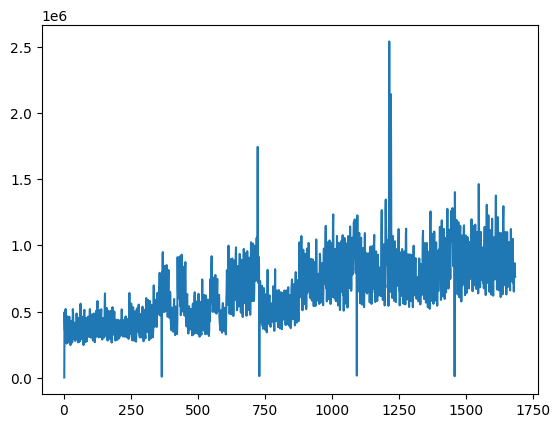

In [24]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.Figure(figsize=(10,11))
plt.plot(tre)